In [1]:
from jupyter_utils import *
%matplotlib inline

from r_utils import *
%load_ext rpy2.ipython

%load_ext autoreload
%autoreload 2

from stats_utils import *
from pandas_ext import *

pd 1.4.2
xr 2022.3.0
np 1.22.3
sns 0.11.2
rpy2 version:
3.4.5
Python version:
3.9.11 (main, Mar 30 2022, 02:45:55) [MSC v.1916 64 bit (AMD64)]
Looking for R's HOME:
    Environment variable R_HOME: C:\Program Files\R\R-4.1.3\
    InstallPath in the registry: C:\Program Files\R\R-4.1.3
    Environment variable R_USER: None
    Environment variable R_LIBS_USER: None
R version:
    In the PATH: 
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:


C:\ProgramData\Anaconda3\envs\q2022\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
matplotlib.rcParams['figure.figsize'] = (15, 10)

# corr

In [3]:
import yfinance as yf

In [4]:
tickers = [
    "^GSPC", "SPY", "^SP500TR", 
    "^RUT", "^RUTTR", 
    "^VIX", "^VVIX", "^MOVE", 
    "^TNX", "^TYX", 
    "CL=F", "QO=F"]

#tickers = ["^GSPC", "^TNX"]

df = yf.download(
    tickers=" ".join(tickers),
    period="max",
    interval="1d",
    group_by=None,
    auto_adjust=True,
    threads=True,
    proxy=None
)
df = df.xs("Close", axis=1, level=1)
df_org = df.copy(True)


[*********************100%***********************]  12 of 12 completed


,Avg Return,Period Return,Volatility,Sharpe
^GSPC,0.075473,95.456568,0.157422,0.479430
^TNX,0.055773,23.750846,0.081908,0.680919


,^GSPC,^TNX
^GSPC,1.000000,0.017844
^TNX,0.017844,1.000000


<AxesSubplot:xlabel='Date'>

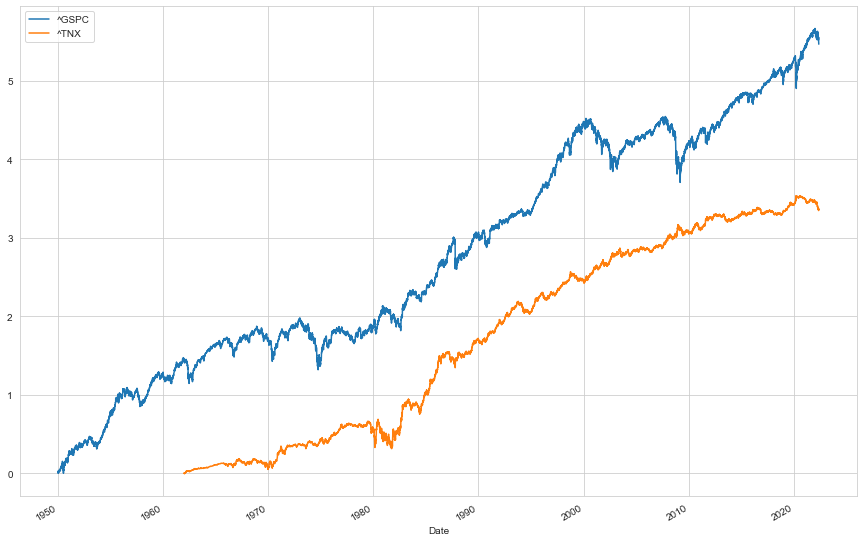

In [49]:
df = df_org.copy(True)

df = df.ffill()

sel = ['^RUTTR', '^SP500TR', 'SPY', '^RUT', 'CL=F', '^GSPC']
df[sel] = df[sel].pct_change()

sel = ['^TNX', '^TYX']
df[sel] = -8 * df[sel].diff()/100 + df[sel].shift()/100/5/52

sel = ["^GSPC", "^TNX"]
df = df[sel]
    
df = np.log(df+1)

df.e.plot_cum_ret() 

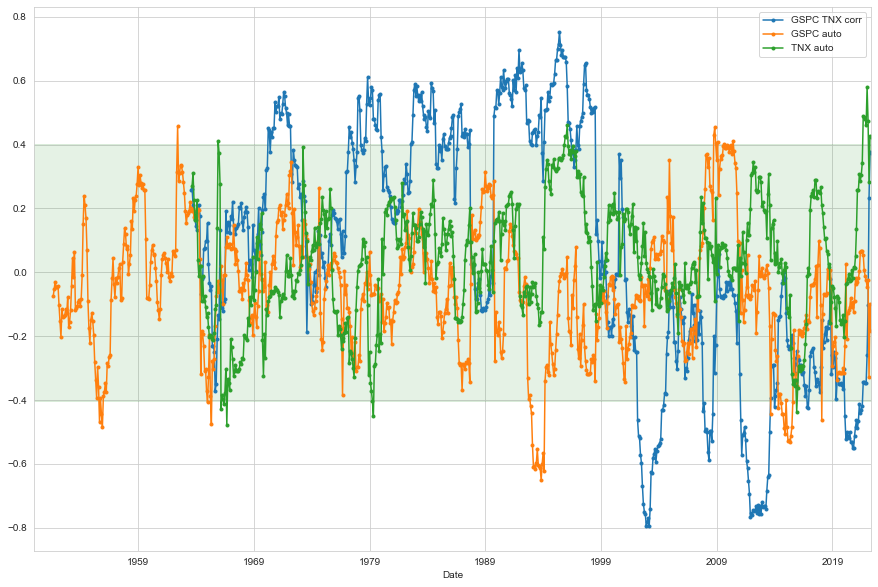

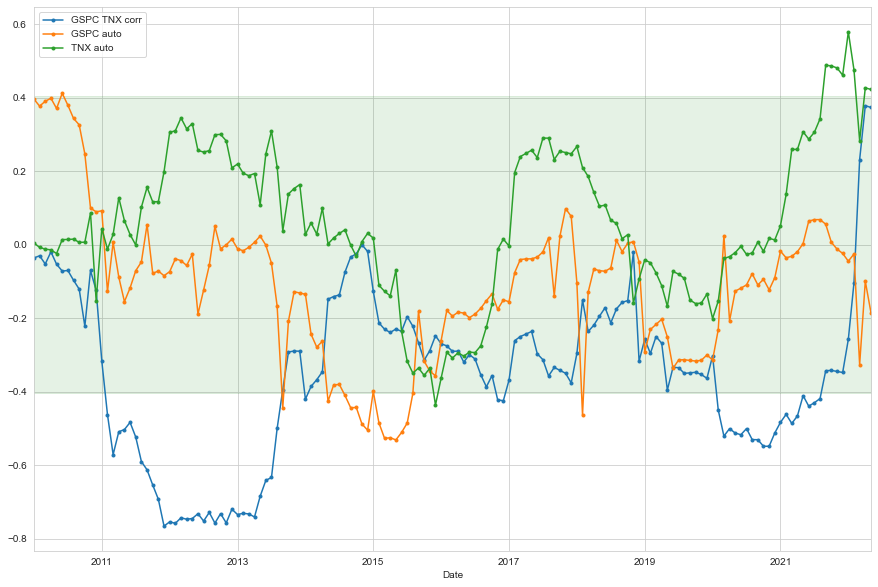

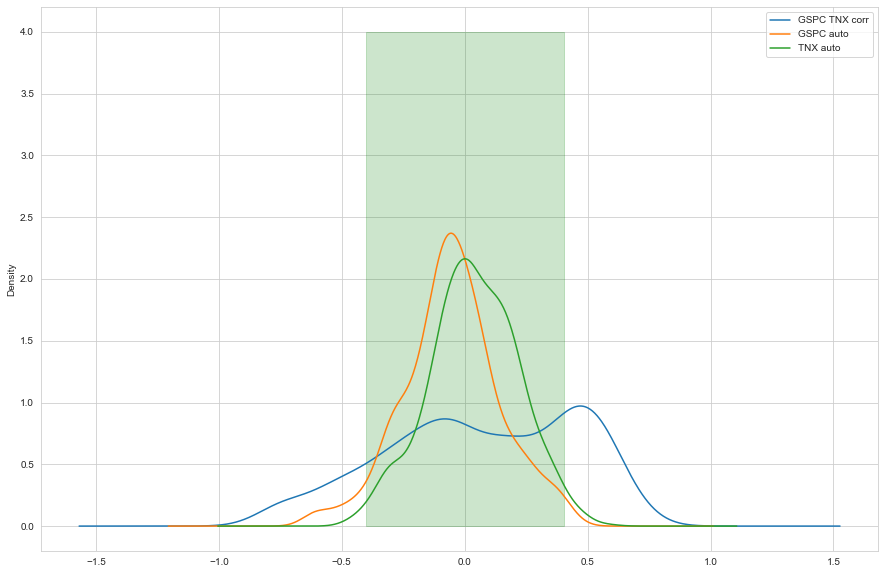

,GSPC TNX corr,GSPC auto,TNX auto
Date,,,
2022-01-31,-0.257656,-0.044981,0.578880
2022-02-28,-0.103565,-0.025403,0.475384
2022-03-31,0.231335,-0.326364,0.283173
2022-04-30,0.378206,-0.099493,0.426664
2022-05-31,0.373305,-0.184918,0.422294


In [6]:
def rolling_corr(df, *args, **kwargs):
    return df.rolling(*args, **kwargs).corr()[df.columns[0]].unstack(1)[df.columns[1]]

def plot_corr(df, window, min_periods=None):
    df_lag = pd.concat([df, df.shift().rename(columns={c: c+"_lag" for c in df_m.columns})], axis=1)
    
    prm = dict(window=window, min_periods=min_periods)
    
    _ = pd.concat([
        rolling_corr(df, **prm).rename("GSPC TNX corr"),
        rolling_corr(df_lag[["^GSPC", "^GSPC_lag"]], **prm).rename("GSPC auto"),
        rolling_corr(df_lag[["^TNX", "^TNX_lag"]], **prm).rename("TNX auto")
    ], axis=1)
    
    
    _.plot(marker=".")
    ci_ = corr_ci(0, prm["window"])
    plt.fill_between([_.index[0], _.index[-1]], ci_[0], ci_[1], color='g', alpha=.1)
    plt.show()

    __ = _[slice("2010", None)]
    __.plot(marker=".")
    plt.fill_between([__.index[0], __.index[-1]], ci_[0], ci_[1], color='g', alpha=.1)
    plt.show()

    _.plot.kde()
    plt.fill_between(ci_, 4, color='g', alpha=.2)
    plt.show()
    
    return _

df_m = df.resample("1M").sum().where(df.notnull().resample("1M").sum()>15)
c_m = plot_corr(df_m, 24, 20)
c_m.tail()

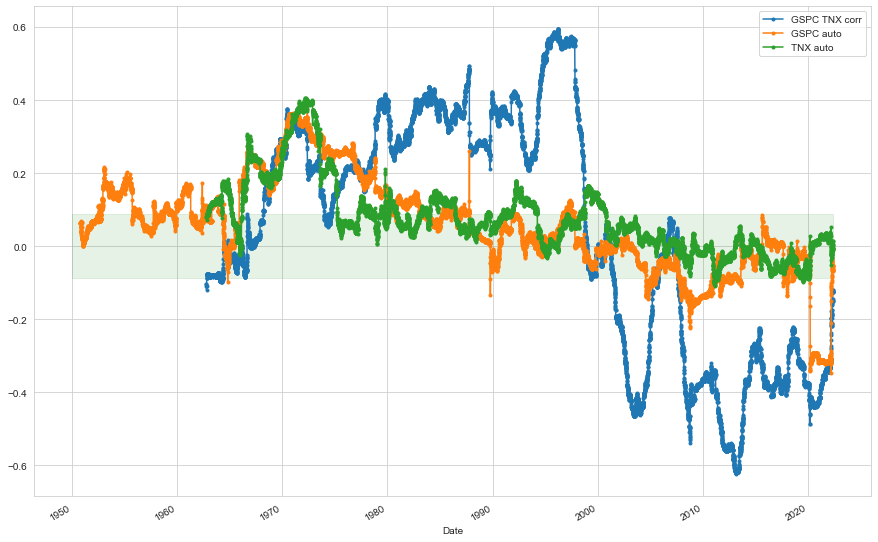

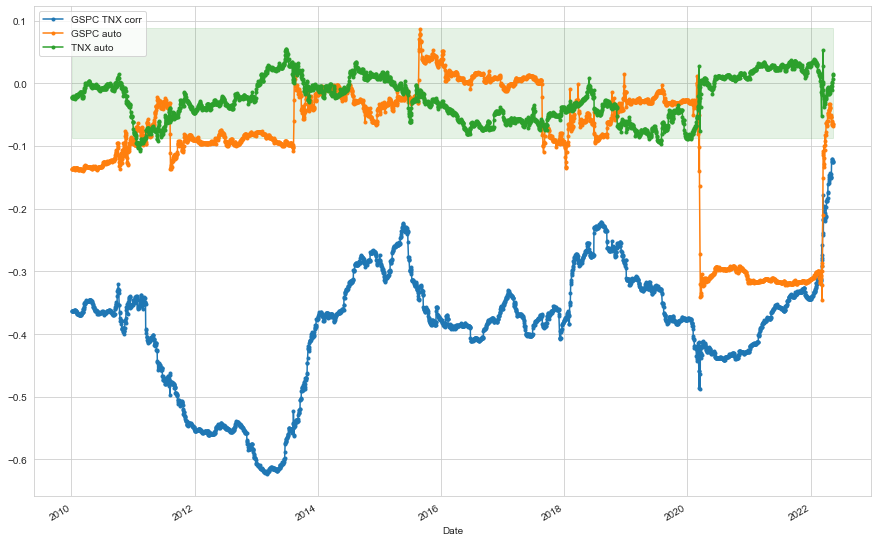

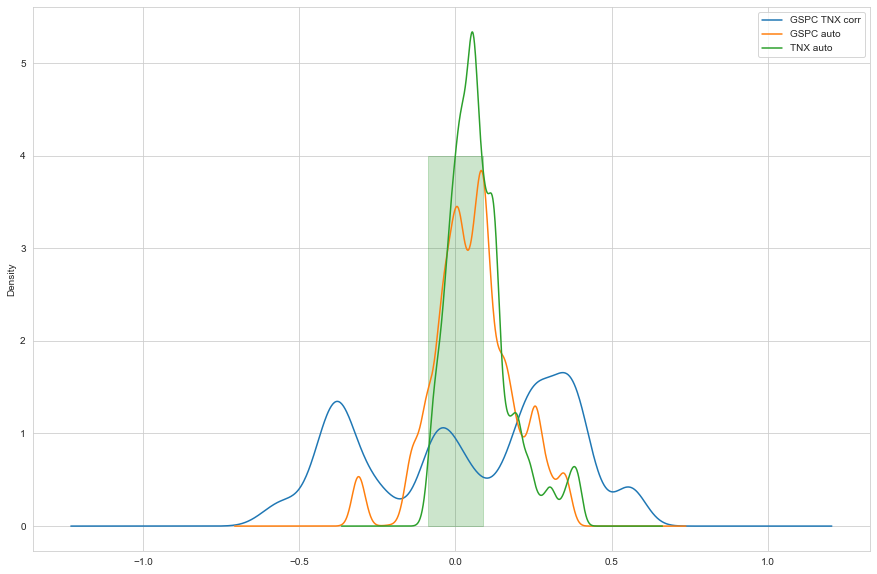

,GSPC TNX corr,GSPC auto,TNX auto
Date,,,
1950-01-31,NaN,NaN,NaN
1950-02-28,NaN,NaN,NaN
1950-03-31,NaN,NaN,NaN
1950-04-30,NaN,NaN,NaN
1950-05-31,NaN,NaN,NaN
...,...,...,...
2022-01-31,-0.327034,-0.301618,0.033088
2022-02-28,-0.313322,-0.318074,0.003044
2022-03-31,-0.213651,-0.082262,-0.023037


In [7]:
c = plot_corr(df, window=2*252, min_periods=200)
c.resample("1M").last()

<AxesSubplot:xlabel='Date'>

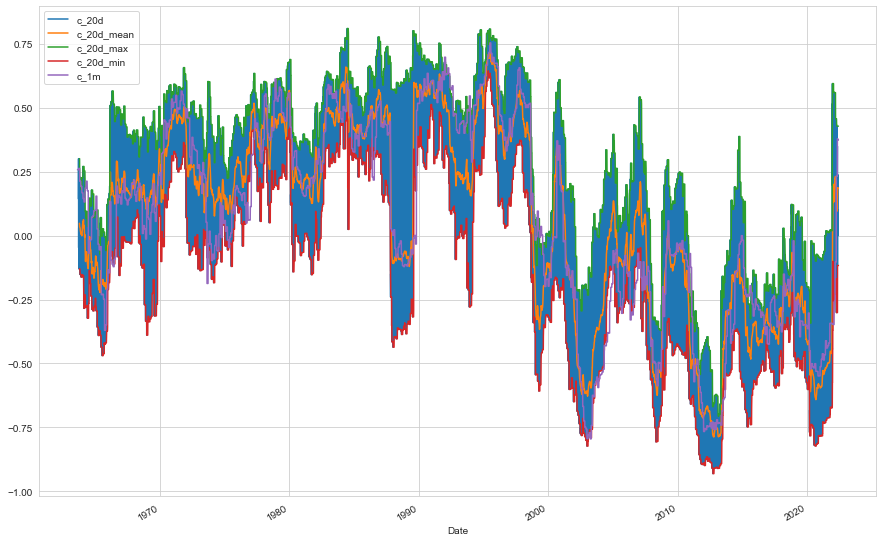

In [8]:
w = 21
c_20 = [
    df.rolling(w, 18).sum()[offset::w].rolling(w).corr().iloc[:, 0].unstack(1).iloc[:, 1]
    for offset in range(w)
]

c_20 = pd.concat(c_20).sort_index().rename("c_20d")

c_mix = pd.concat([
    c_20,
    c_20.rolling(w).mean().rename("c_20d_mean"),
    c_20.rolling(w).max().rename("c_20d_max"),
    c_20.rolling(w).min().rename("c_20d_min"),
    c_m["GSPC TNX corr"].rename("c_1m")
], axis=1)
c_mix.ffill().plot()

<AxesSubplot:xlabel='Date'>

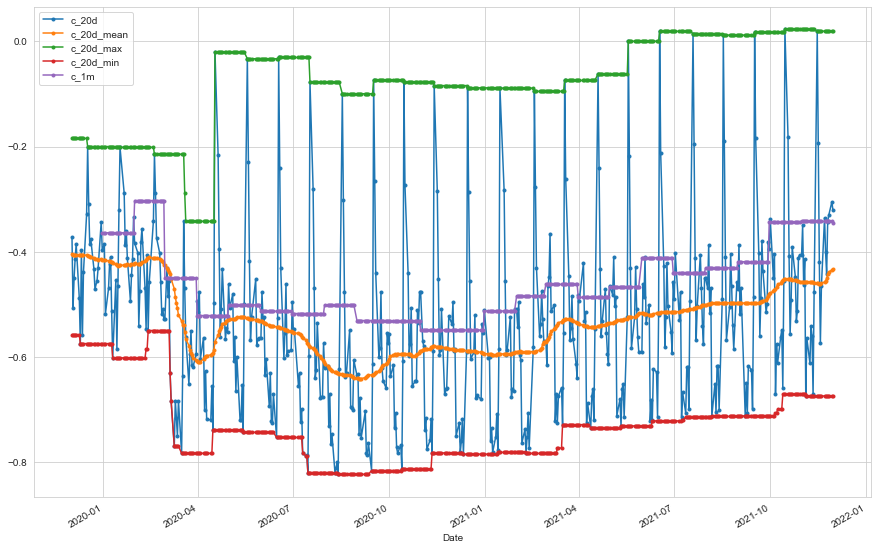

In [9]:
c_mix[slice("Dec 2019", "Nov 2021")].ffill().plot(marker=".")

<AxesSubplot:xlabel='Date'>

<AxesSubplot:xlabel='Date'>

<AxesSubplot:xlabel='Date'>

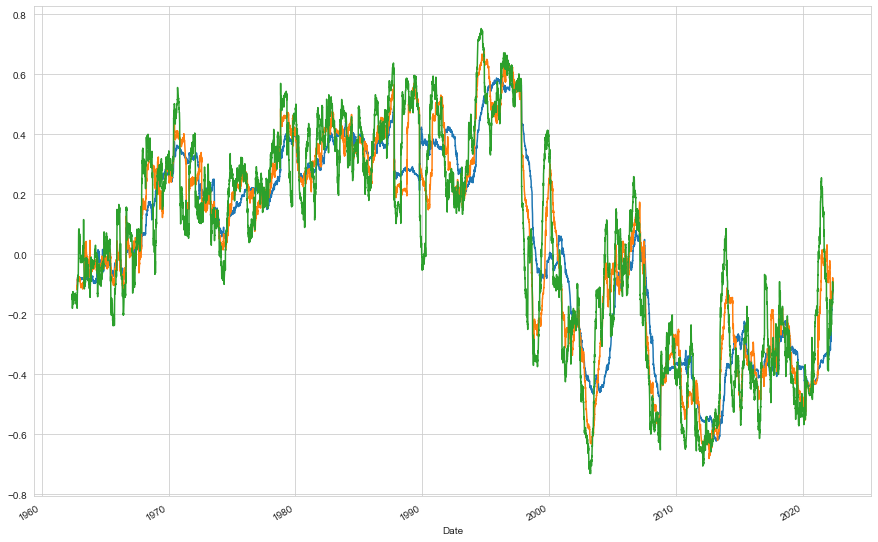

In [10]:
df.rolling(252*2, 200).corr().iloc[:, 0].unstack(1).iloc[:, 1].plot()
df.rolling(252, 200).corr().iloc[:, 0].unstack(1).iloc[:, 1].plot()
df.rolling(252//2, 100).corr().iloc[:, 0].unstack(1).iloc[:, 1].plot()

<AxesSubplot:xlabel='Date'>

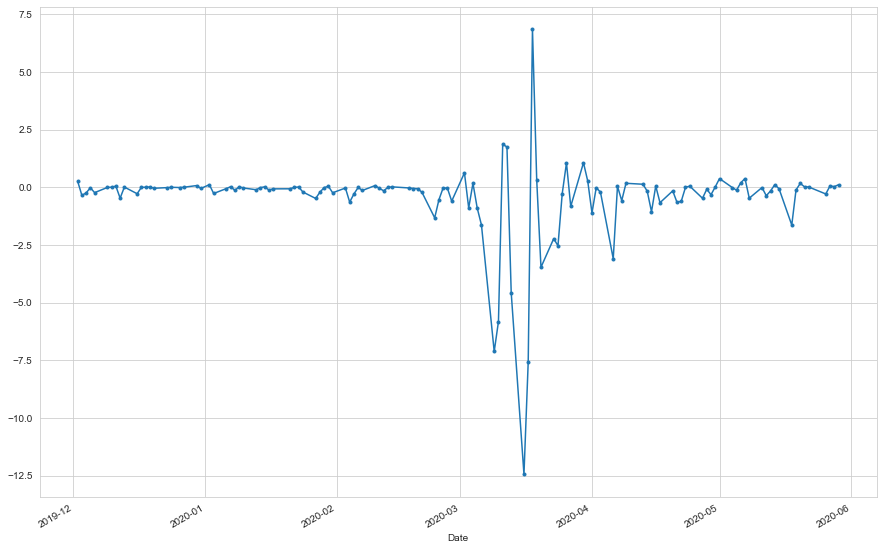

In [40]:
#df.index = df.index.to_frame().iloc[:, 0].dt.date()
df[slice("Dec 2019", "May 2020")].e.normalise().prod(axis=1).plot(marker=".")

In [16]:
corr_ci(0.5, 24)

(0.12101101235305807, 0.7517666193783058)

<AxesSubplot:ylabel='Density'>

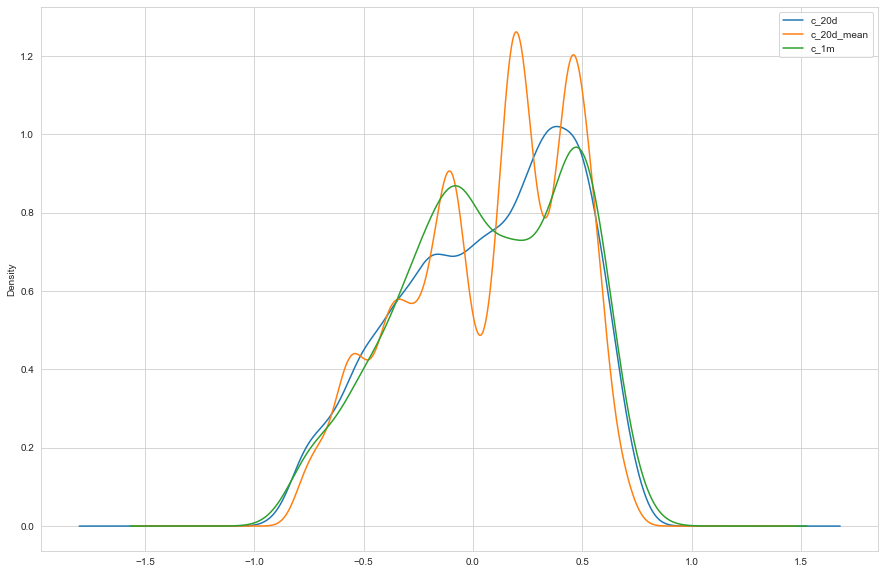

In [129]:
c_mix.plot.kde()

<AxesSubplot:ylabel='Density'>

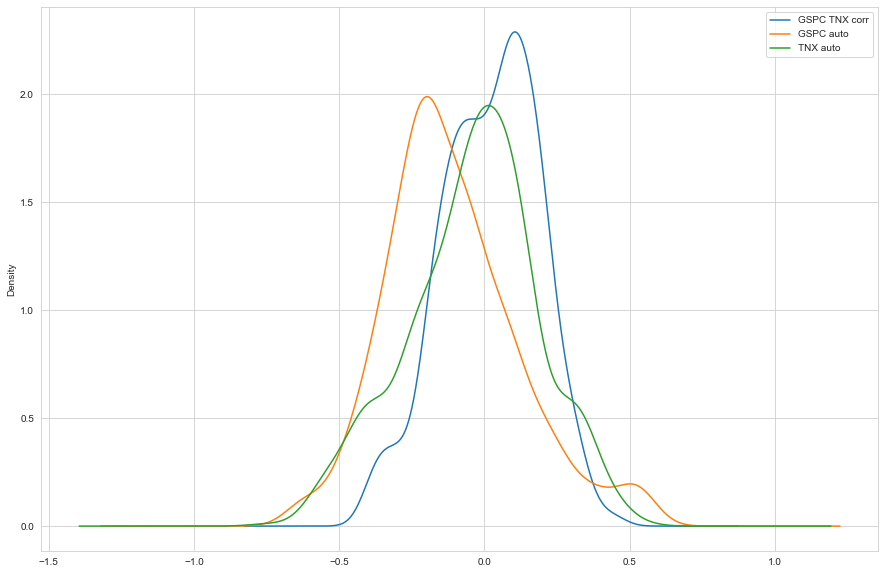

In [71]:
c_diff = c_m - c.resample("1M").last()
c_diff.plot.kde()

<AxesSubplot:xlabel='Date'>

<AxesSubplot:xlabel='Date'>

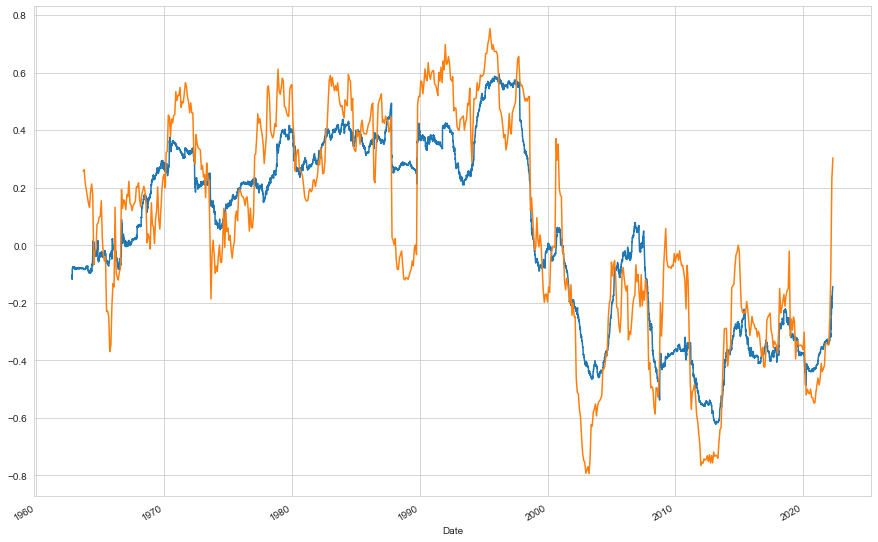

In [79]:
c["GSPC TNX corr"].dropna().plot()
c_m["GSPC TNX corr"].dropna().plot()

<AxesSubplot:xlabel='Date'>

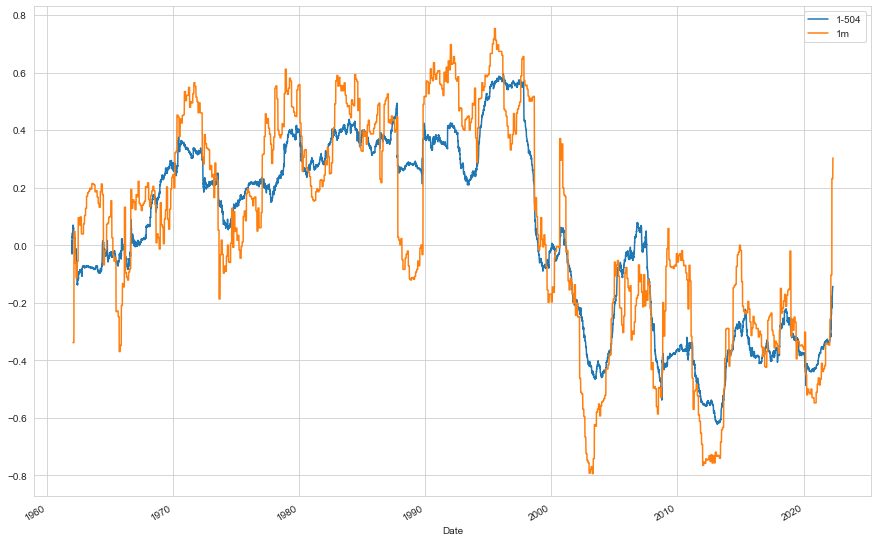

<AxesSubplot:xlabel='Date'>

1-504   -0.143913
1m       0.303217
dtype: float64

[-0.08734161408060717,
 -0.1964181176820594,
 -0.27834771852853907,
 -0.3951308987662967,
 -0.40339670976097614]

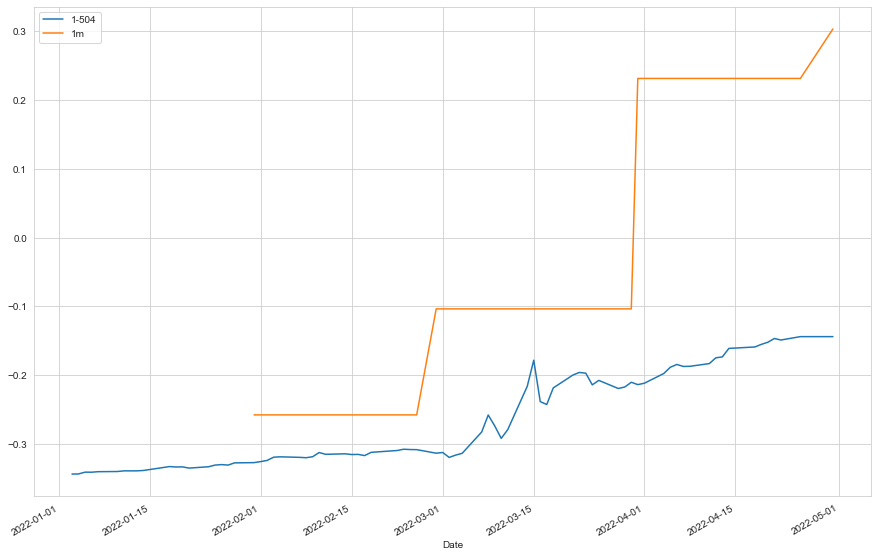

In [78]:
def _plot_cor(a, v, w):
    a = a.copy(True)
    a = a.rolling(v, min_periods=int(v/2)).sum()[::v]
    a = a.rolling(w, min_periods=int(w/2)).corr()
    return a["^GSPC"].unstack(1)["^TNX"].rename(f"{v}-{w}")

y = 252*2
corr_mix = pd.concat([
    _plot_cor(df, v=1, w=y),
    #_plot_cor(df, v=5, w=int(y/5)),
    #_plot_cor(df, v=10, w=int(y/10)),
    #_plot_cor(df, v=20, w=int(y/20)),
    df.resample("1m").sum().rolling(int(12*y/252)).corr()["^GSPC"].unstack(1)["^TNX"].rename(f"1m")
], axis=1)

corr_mix.ffill().plot()
plt.show()
corr_mix[slice("2022", None)].ffill().plot()

corr_mix[slice("2022", None)].max()

obs = [y, int(y/5), int(y/10), int(y/20), int(12*y/252)]
ci = [corr_ci(0, obs)[0] for obs in obs]
ci

In [21]:
corr_mix[["20-25", "1m"]].dropna(how="all")[-20:]
(corr_mix[["20-25", "1m"]]-corr_mix["5-100"].ffill()[:, None]).dropna(how="all")[-20:]

,20-25,1m
Date,,
2021-07-28,-0.477001,NaN
2021-07-31,NaN,-0.430135
2021-08-25,-0.488461,NaN
2021-08-31,NaN,-0.418830
2021-09-23,-0.488813,NaN
2021-09-30,NaN,-0.343082
2021-10-21,-0.480976,NaN
2021-10-31,NaN,-0.342203
2021-11-18,-0.480624,NaN


C:\Users\Andreas\AppData\Local\Temp\ipykernel_11092\3941990364.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (corr_mix[["20-25", "1m"]]-corr_mix["5-100"].ffill()[:, None]).dropna(how="all")[-20:]


,20-25,1m
Date,,
2021-07-28,-0.240486,NaN
2021-07-31,NaN,-0.193620
2021-08-25,-0.251192,NaN
2021-08-31,NaN,-0.181560
2021-09-23,-0.256821,NaN
2021-09-30,NaN,-0.131134
2021-10-21,-0.263206,NaN
2021-10-31,NaN,-0.125367
2021-11-18,-0.258776,NaN


C:\Users\Andreas\AppData\Local\Temp\ipykernel_11092\931901023.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  corr_mix_diff = corr_mix.iloc[:, 1:] - corr_mix.iloc[:, 0][:, None]


<AxesSubplot:ylabel='Density'>

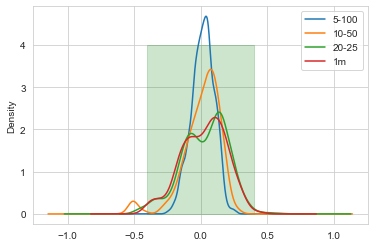

<AxesSubplot:xlabel='Date'>

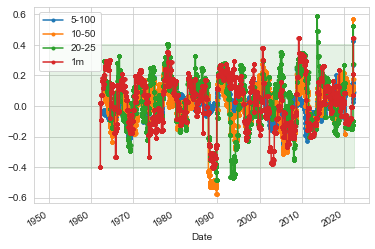

,5-100,10-50,20-25,1m
0.025,-0.157679,-0.487259,-0.353207,-0.349899
0.975,0.165213,0.204006,0.322397,0.299148


,5-100,10-50,20-25,1m
Date,,,,
2022-04-12,0.115105,0.176943,0.273468,0.444986
2022-04-13,0.115105,0.176943,0.273468,0.444986
2022-04-14,0.115105,0.176943,0.273468,0.444986
2022-04-18,0.115105,0.176943,0.273468,0.444986
2022-04-19,0.115105,0.176943,0.273468,0.444986
2022-04-20,0.091059,0.176943,0.273468,0.444986
2022-04-21,0.091059,0.176943,0.273468,0.444986
2022-04-22,0.091059,0.176943,0.273468,0.444986
2022-04-25,0.091059,0.176943,0.273468,0.444986


In [22]:
ci_ = ci[-1]
corr_mix_diff = corr_mix.iloc[:, 1:] - corr_mix.iloc[:, 0][:, None]
corr_mix_diff.plot.kde()
plt.fill_between([-ci_, ci_], 4, color='g', alpha=.2)
plt.show()

corr_mix_diff.ffill().plot(marker=".")
plt.fill_between([corr_mix_diff.index[0], corr_mix_diff.index[-1]], -ci_, ci_, color='g', alpha=.1)
plt.show()


corr_mix_diff.quantile([0.025, 0.975])
corr_mix_diff.ffill()[-10:]

In [23]:
x = df[slice("2021-02-26", "2022-02-24")]
x21 = x.rolling(21, min_periods=18).sum()
x2121 = x.rolling(21, min_periods=18).sum()[::21]
x.corr().iloc[0, 1], x21.corr().iloc[0, 1], x2121.corr().iloc[0, 1], x.resample("1M").sum().corr().iloc[0, 1]

(-0.08777826810965708,
 0.41921516585816965,
 0.4728347747366626,
 0.4203327689748554)

<AxesSubplot:xlabel='Date'>

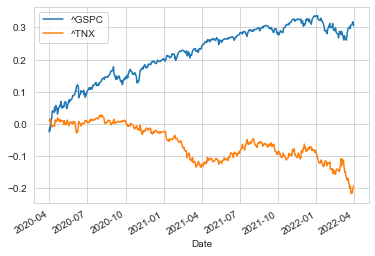

<AxesSubplot:xlabel='Date'>

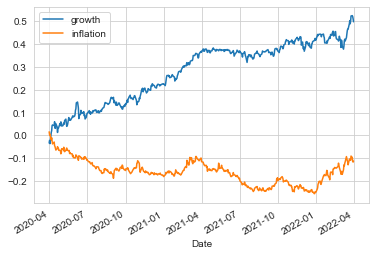

,0,1
d,-0.219794,0.000000
d21,0.121042,0.340837
d2121,0.298893,0.518687
m,0.231335,0.451129


<AxesSubplot:xlabel='^GSPC', ylabel='^TNX'>

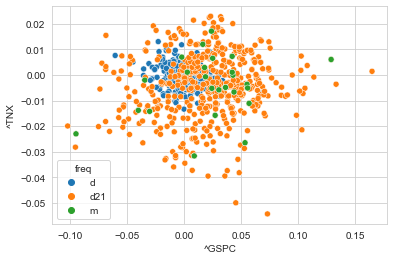

In [25]:
#x = a[slice("2020-03-25", "2022-03-16")]
x = df[slice("2020-03-25", "2022-03-16")]
x = df[slice("2020-04-01", "2022-03-31")]
#x = a[slice("2019-04-01", "2022-03-31")]

x0 = normalise(x, target_mean=x.mean(), target_vol=0.1/np.sqrt(252))

x0.cumsum().plot()
plt.show()

gi = pd.concat([
    (x0["^GSPC"]-x0["^TNX"]).rename("growth"),
    (-x0["^GSPC"]-x0["^TNX"]).rename("inflation")
], axis=1)
gi.cumsum().plot()
plt.legend()
plt.show()

x21 = x.rolling(20, min_periods=18).sum()
x2121 = x21[19::20]
x21210 = normalise(x2121)
xm = x.resample("1M").sum()
xm0 = normalise(xm)

cor = pd.Series({
    "d": x.corr().iloc[0, 1], 
    "d21": x21.corr().iloc[0, 1], 
    "d2121": x2121.corr().iloc[0, 1], 
    "m": xm.corr().iloc[0, 1],
})

pd.concat([cor, cor - cor["d"]], axis=1)

sns.scatterplot(
    data=pd.concat([x, x21, x2121, xm], keys=["d", "d21", "m"]).reset_index().rename(columns={"level_0": "freq"}),
    x="^GSPC", 
    y="^TNX",
    hue="freq"
)

plt.show()

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

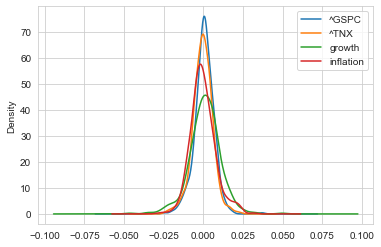

In [26]:
x0.plot.kde()
gi.plot.kde(ax=plt.gca())

In [27]:
x.index.min(), x.index.max()
xx.me.min(), xx.me.max()

(Timestamp('2020-04-01 00:00:00'), Timestamp('2022-03-31 00:00:00'))

NameError: name 'xx' is not defined

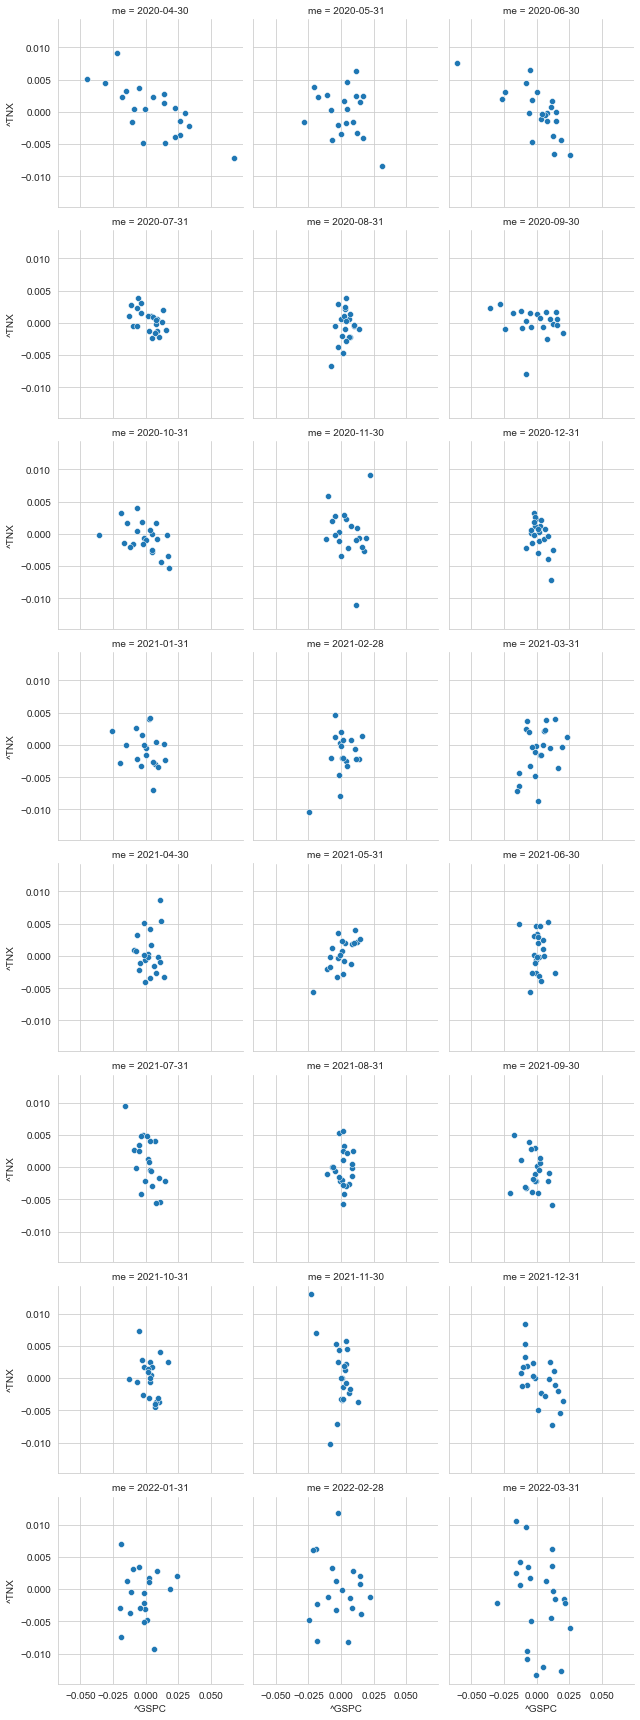

In [626]:
xx = x.reset_index()
xx["me"] = xx.Date + pd.offsets.MonthEnd(0)
xx["me"] = xx.me.dt.date

g = sns.FacetGrid(data=xx, col="me", col_wrap=3)
g.map(sns.scatterplot, "^GSPC", "^TNX")


In [516]:
xm0.prod(axis=1).mean()
xm.prod(axis=1).mean()

0.22169575908080982

2.9335113833352673e-05

In [517]:
from statsmodels.tsa.api import VAR
agg_win = 1
m_ = VAR(x.rolling(agg_win).sum()[agg_win-1::agg_win])
m = m_.fit(maxlags=5, ic="bic", trend="ct")

m.summary()

C:\ProgramData\Anaconda3\envs\q2022\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Apr, 2022
Time:                     19:15:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -20.1954
Nobs:                     506.000    HQIC:                  -20.2157
Log likelihood:           3685.92    FPE:                1.63963e-09
AIC:                     -20.2288    Det(Omega_mle):     1.62674e-09
--------------------------------------------------------------------
Results for equation ^GSPC
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.002576         0.001028            2.506           0.012
trend        -0.000006         0.000004           -1.647           0.100

Results for equation ^TNX
           coefficient       std. error           t-stat         

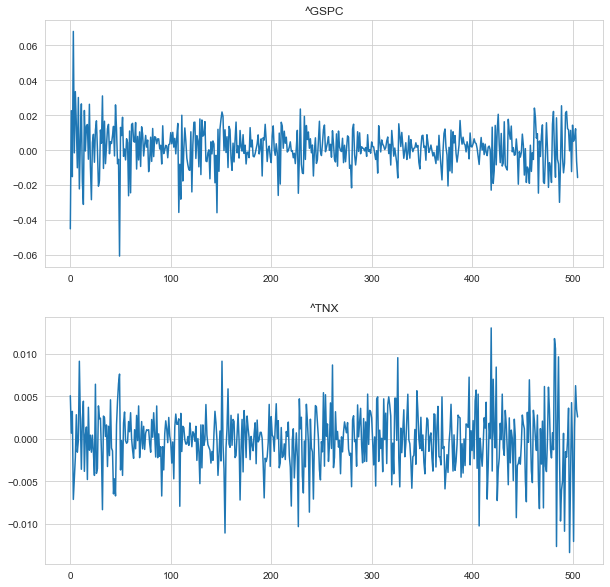

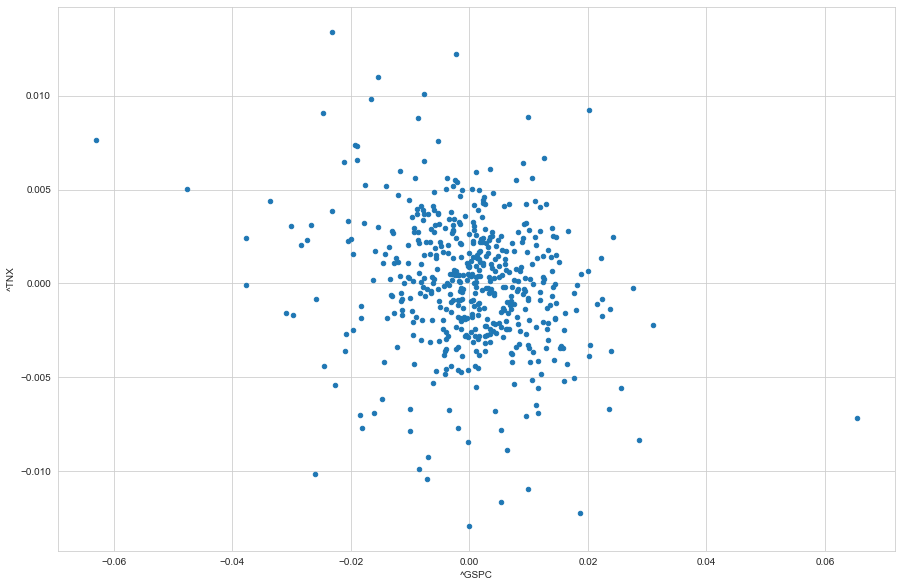

In [518]:
m.plot();
m.resid.plot.scatter("^GSPC", "^TNX");

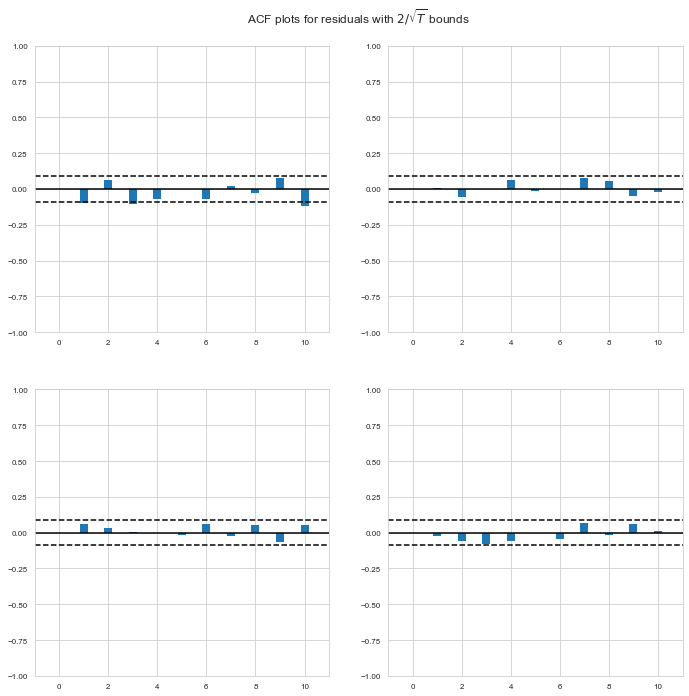

In [519]:
m.plot_acorr();

In [520]:
irf = m.irf(21)
irf.plot(orth=False);

ValueError: need at least one array to concatenate

In [44]:
def corr_0(x):
    return x.prod(axis=1).mean() / ((x**2).mean().prod()**0.5)

In [522]:
def my_(a, af=1):
    return pd.DataFrame({
        "ret": a.mean() * af,
        "vol": a.std() * np.sqrt(af),
        "corr": [a.corr().iloc[0, 1], my_corr_0(a)],
        "auto": a.corrwith(a.shift(1)),
        "auto": a.corrwith(a.shift(1)),
    }).T.round(6)

pd.concat([
    my_(x, 1),
    my_(x0, 1),
    my_(x2121, 1),
    my_(x21210, 1/20),
    my_(xm, 1),
    my_(xm0, 1/20),
], keys=["x", "x0", "x2121", "x21210", "xm", "xm0"], axis=1).T

ret       vol      corr      auto
x      ^GSPC  0.001109  0.011565 -0.219794 -0.095601
       ^TNX  -0.000217  0.003583 -0.224161 -0.022257
x0     ^GSPC  0.000000  1.000000 -0.219794 -0.095601
       ^TNX  -0.000000  1.000000 -0.219794 -0.022257
x2121  ^GSPC  0.021790  0.042108  0.298893 -0.091106
       ^TNX  -0.004383  0.011762  0.081020  0.326886
x21210 ^GSPC -0.000000  0.223607  0.298893 -0.091106
       ^TNX   0.000000  0.223607  0.298893  0.326886
xm     ^GSPC  0.023385  0.044679  0.231335 -0.082673
       ^TNX  -0.004567  0.013744  0.041629  0.230352
xm0    ^GSPC -0.000000  0.223607  0.231335 -0.082673
       ^TNX   0.000000  0.223607  0.231335  0.230352

In [423]:
x_ = x.rename(columns={'^GSPC': "sp", '^TNX': "tx"}).shift()
pd.concat([x, x_], axis=1).corr()
x.corrwith(x.shift())

,^GSPC,^TNX,sp,tx
^GSPC,1.000000,-0.219794,-0.095601,0.013617
^TNX,-0.219794,1.000000,0.060875,-0.022257
sp,-0.095601,0.060875,1.000000,-0.218136
tx,0.013617,-0.022257,-0.218136,1.000000


^GSPC   -0.095601
^TNX    -0.022257
dtype: float64

In [281]:
x2121.corr(), my_corr_0(x2121), my_corr_0(x21210)

(asset     ^GSPC      ^TNX
 asset                    
 ^GSPC  1.000000 -0.321773
 ^TNX  -0.321773  1.000000,
 -0.04260398964896349,
 -0.32177267564790674)

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

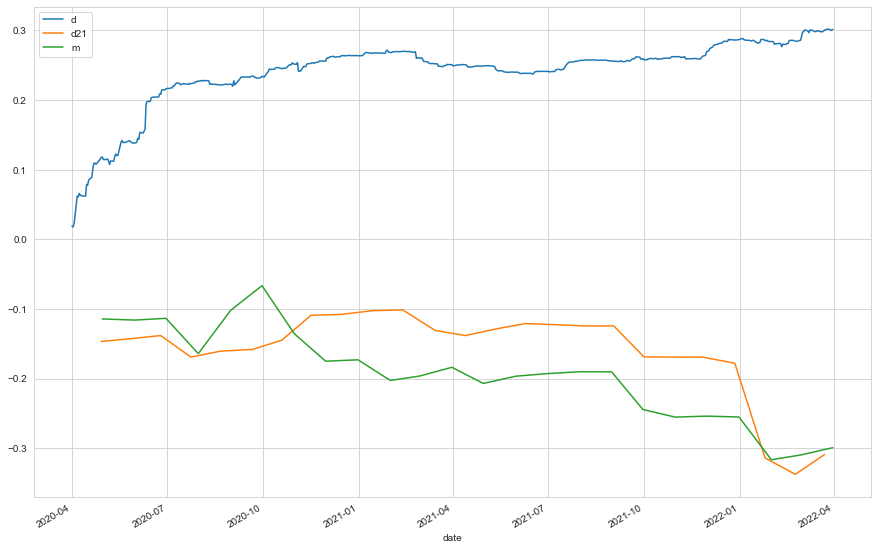

<AxesSubplot:xlabel='date'>

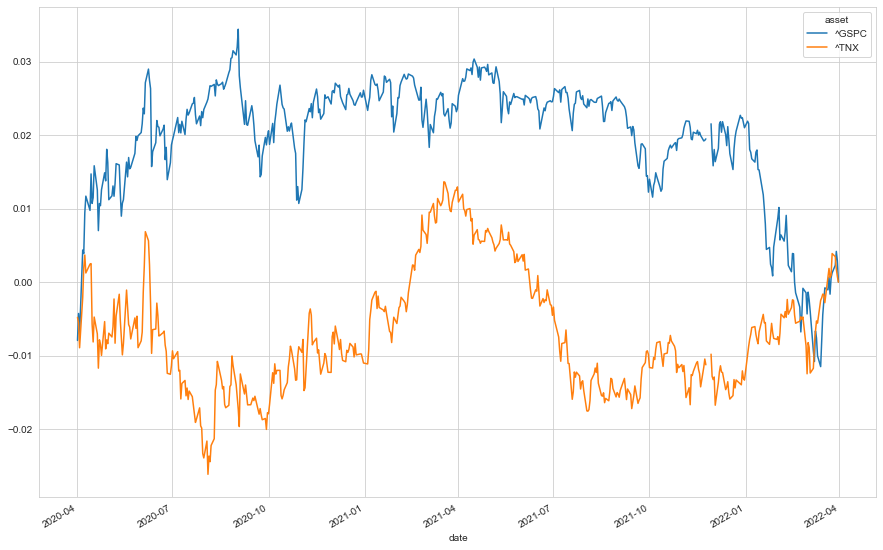

In [258]:
(x.prod(axis=1).cumsum()/x.shape[0]).plot()
(x21210.prod(axis=1).cumsum()/x21210.shape[0]).plot()
(xm0.prod(axis=1).cumsum()/xm0.shape[0]).plot()
plt.legend(["d", "d21", "m"])
plt.show()

(x.cumsum()/x.shape[0]).plot()

<AxesSubplot:xlabel='date'>

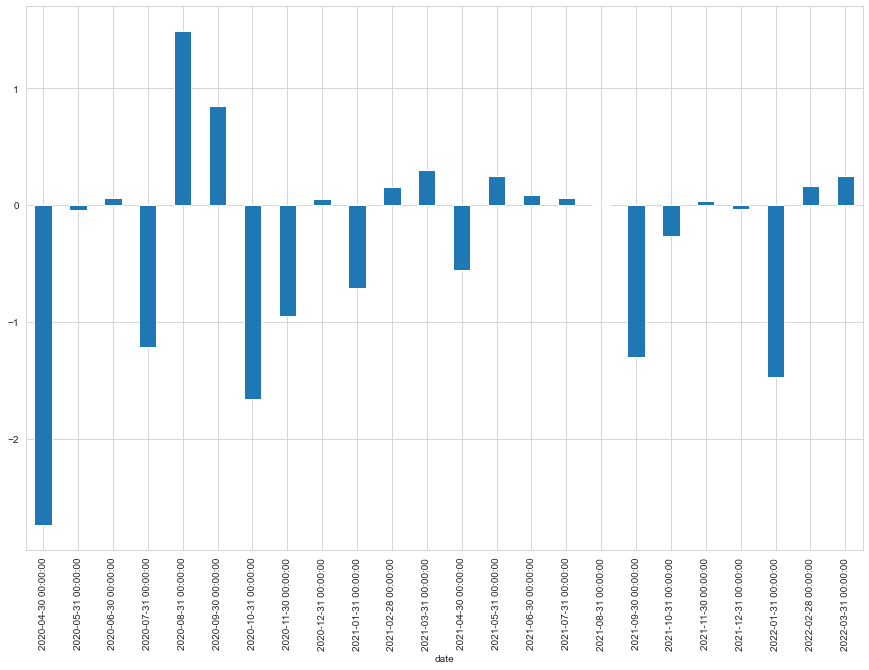

In [267]:
x0.prod(axis=1)
xm0.prod(axis=1).plot.bar()

<AxesSubplot:xlabel='^GSPC'>

<AxesSubplot:xlabel='^GSPC', ylabel='^TNX'>

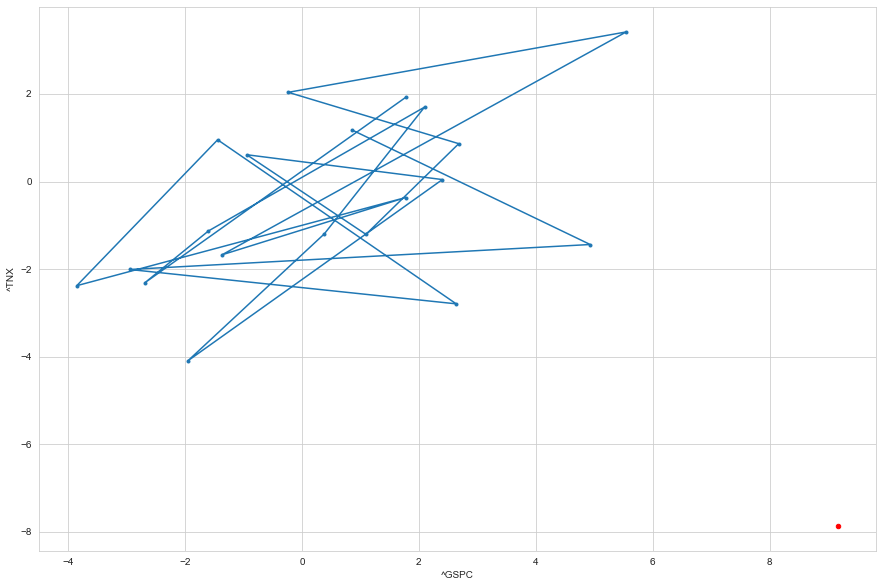

In [224]:
x.iloc[:20].set_index("^GSPC")["^TNX"].plot(marker=".")
pd.DataFrame(x.iloc[:20].sum()).T.plot.scatter("^GSPC", "^TNX", ax=plt.gca(), c="red")

In [21]:
corr_ci(0, n=26)

(-0.3873519389039342, 0.38735193890393427)

In [22]:
b = a[slice("Mar 2021", "Mar 2022")]
c = b.rolling(21, 18).sum()
pd.Series([
    b.corr().iloc[0, 1],
    c.corr().iloc[0, 1],
    c[::21].corr().iloc[0, 1],
])

pd.concat([
    b.mean()*21,
    c.mean(),
    c[::21].mean(),
], axis=1)


0    0.106627
1   -0.303543
2   -0.483897
dtype: float64

,0,1,2
asset,,,
^GSPC,0.015890,0.012741,0.014922
^TNX,0.053161,0.043845,0.059037


<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

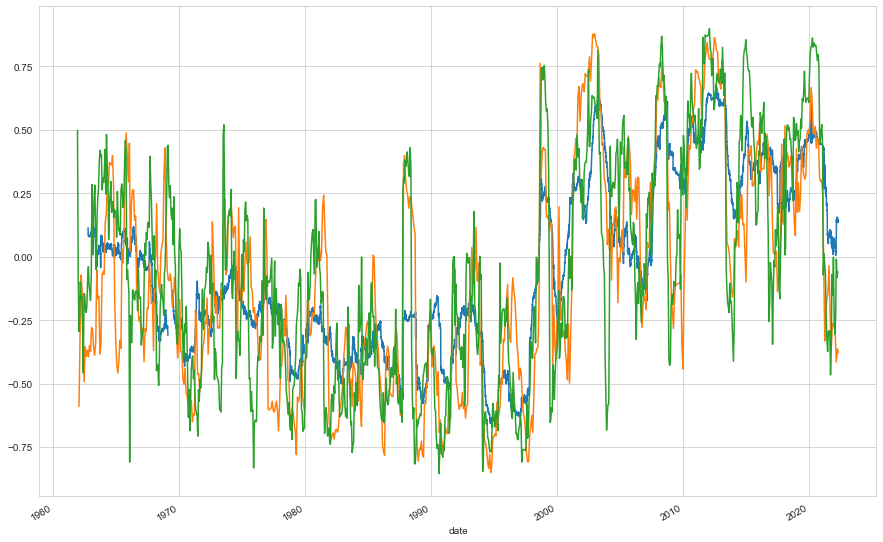

In [23]:
a.rolling(252, 200).corr()["^GSPC"].unstack(1)["^TNX"].plot()
a.resample("1M").sum().rolling(12, 10).corr()["^GSPC"].unstack(1)["^TNX"].plot()
a.resample("21D").sum().rolling(12, 10).corr()["^GSPC"].unstack(1)["^TNX"].plot()

In [24]:
a = dx.sel(
    asset=["^GSPC", "^TNX"],
    field="Close"
).to_pandas()
a = np.log(a+1)

In [46]:
a = df.fillna(0.).where(a.ffill().notnull()).dropna()

In [47]:
%%R -i a
library(parallel)
library(rugarch)
library(rmgarch)

uspec = ugarchspec(mean.model = list(armaOrder = c(0, 0)), )
mspec = multispec(replicate(2, uspec))
dcc11spec = dccspec(mspec, dccOrder=c(1, 1))
fit = dccfit(dcc11spec, data=a)

R[write to console]: 
Attaching package: 'rugarch'


R[write to console]: The following object is masked from 'package:stats':

    sigma





*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  11
[VAR GARCH DCC UncQ] : [0+8+2+1]
No. Series           :  2
No. Obs.             :  506
Log-Likelihood       :  3741.959
Av.Log-Likelihood    :  7.4 

Optimal Parameters
-----------------------------------
                Estimate  Std. Error  t value Pr(>|t|)
[^GSPC].mu      0.001134    0.000388  2.92006 0.003500
[^GSPC].omega   0.000010    0.000005  1.96950 0.048895
[^GSPC].alpha1  0.300968    0.070761  4.25329 0.000021
[^GSPC].beta1   0.659368    0.114944  5.73645 0.000000
[^TNX].mu      -0.000049    0.000136 -0.36289 0.716687
[^TNX].omega    0.000001    0.000001  1.06564 0.286588
[^TNX].alpha1   0.135766    0.035756  3.79698 0.000146
[^TNX].beta1    0.798345    0.024034 33.21687 0.000000
[Joint]dcca1    0.037850    0.022339  1.69431 0.090206
[Joint]dccb1    0.932648    0.042635 21.8753

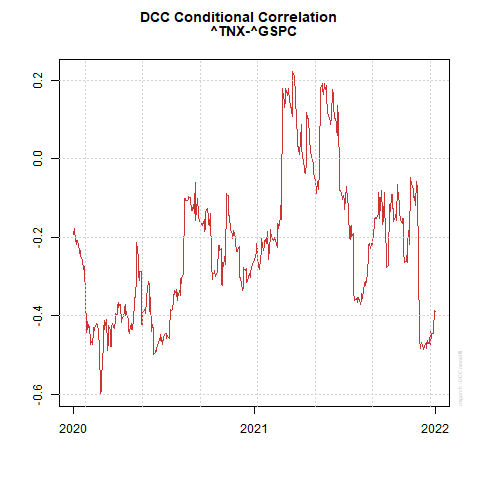

In [48]:
%%R -o cor
show(fit)
summary(fit)
plot(fit, which=4)
cor = rcor(fit)

In [49]:
a["^GSPC"].autocorr(), a["^TNX"].autocorr()
corr_ci(0, a.shape[0], 0.05)

a_ = a[slice("2021", None)]
a_["^GSPC"].autocorr(), a_["^TNX"].autocorr()
corr_ci(0, a_.shape[0], 0.05)

(-0.31328369993813915, 0.02838515591648681)

(-0.08716868244222203, 0.08716868244222202)

(-0.07444789647308446, -0.07540603152674422)

(-0.12332797349174394, 0.12332797349174394)

In [70]:
import performanceanalytics.statistics as pas
dir(pat)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'calendar_returns',
 'capm_table',
 'collections',
 'create_downside_table',
 'dd_to_dict',
 'downside_stats',
 'drawdown_table',
 'geo_mean_return',
 'kurtosis',
 'mean_confidence_interval',
 'np',
 'pad',
 'parse_cols',
 'pas',
 'pd',
 'replace_col_names',
 'sem',
 'series_stats',
 'skew',
 'stats_table']

In [72]:
import performanceanalytics.table.table as pat
pat.stats_table(df, manager_col=0, other_cols=[0, 1])
pat.create_downside_table(df)#, [0, 1])

#pas.modigliani_ratio(a[:, 0], a.iloc[:, 1], .01)

,^GSPC,^GSPC,^TNX
Observations,18229.000000,18229.000000,15216.000000
NAs,1.000000,1.000000,3014.000000
Minimum,-0.228997,-0.228997,-0.052906
Quartile 1,-0.004036,-0.004036,-0.002086
Median,0.000480,0.000480,0.000233
Artithmetic Mean,0.000304,0.000304,0.000222
Geometric Mean,0.000255,0.000255,0.000208
Quartile 3,0.005002,0.005002,0.002594
Maximum,0.109572,0.109572,0.058637
SE Mean,0.000073,0.000073,0.000042


TypeError: create_downside_table() missing 1 required positional argument: 'managercols'

# dcc midas

In [57]:
%%R
R.version.string
file.path(R.home("bin"), "R")
library(dccmidas)
library(xts)

In [58]:
%%R -i a -o rcov -o cdcc_est
library(dccmidas)
library(xts)

a = xts(a, order.by=as.Date(rownames(a)))

# open to close daily log-returns
r_t = list(a[,1],a[,2])
K_c = 144
N_c = 36

cdcc_est<-dcc_fit(
    r_t,
    univ_model="sGARCH", 
    distribution="norm", 
    corr_model="DCCMIDAS",
    N_c=N_c, 
    K_c=K_c
)

rcov = cov_eval(cdcc_est$H_t,r_t=r_t)[(K_c+1):dim(cdcc_est$H_t)[3]]

First step: completed 


In [60]:
%%R
dim(indpro)
dim(sp500)
names(sp500)

[1] "open_price"  "rv5"         "close_price"


In [62]:
%%R -o cor_bar -o cor
summary(cdcc_est)
#cdcc_est$corr_coef_mat
cor_bar = cdcc_est$R_t_bar[1,2,]
cor = cdcc_est$R_t[1,2,]


Univariate model: sGARCH 

Est. coefficients of the univariate models:

$`^GSPC`
        Estimate  Std. Error  t value Pr(>|t|) Sig.
omega     0.0000      0.0000   3.6488    3e-04  ***
alpha1    0.2766      0.0655   4.2225    0e+00  ***
beta1     0.6807      0.0606  11.2234    0e+00  ***

$`^TNX`
        Estimate  Std. Error  t value Pr(>|t|) Sig.
omega     0.0000      0.0000   0.1000   0.9203     
alpha1    0.1352      0.0488   2.7686   0.0056  ***
beta1     0.7995      0.1127   7.0951   0.0000  ***

--------------------------------------------------- 
Correlation model: DCC-MIDAS 

Est. coefficients of the correlation model:

   Estimate Std. Error t value Pr(>|t|) Sig.
a    0.0462     0.0244  1.8929   0.0584    *
b    0.9402     0.0377 24.9210   0.0000  ***
w2   2.1427     2.6118  0.8204   0.4120     
--- 
Signif. codes: 0.01 '***', 0.05 '**', 0.1 '*' 

Obs.: 506. Sample Period: 2020-01-02/2021-12-31 

LogLik: -662.077. AIC: 1330.154 BIC: 1342.834 



<AxesSubplot:xlabel='Date'>

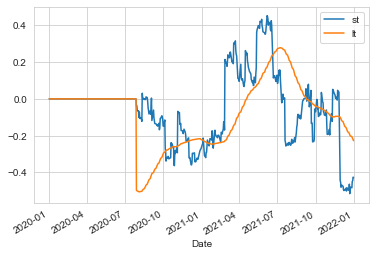

In [63]:
pd.DataFrame([cor, cor_bar], columns=a.index, index=["st", "lt"]).T.plot()

# corr asymmetry

In [161]:
# https://www.statestreet.com/content/dam/statestreet/documents/Articles/jpm-the-myth-of-diversification-reconsidered.pdf

In [162]:
df0 = df.copy(True)

In [168]:
df = df0.resample("1M").sum()
df.columns = ["stocks", "bonds"]
df = df[slice("1976", "2019")] # as in paper
df = df.e.normalise()
thresholds = np.arange(0.00001, 2.02, 0.1)
thresholds = (-thresholds).tolist()[::-1] + thresholds.tolist()

In [196]:
def corr_0(df):
    c = (df.values[:, :, None] * df.values[:, None, :])
    c = np.nansum(c, axis=0)
    v = 1 / np.diag(c) ** 0.5
    c = v[:, None] * c * v[None, :]
    c = pd.DataFrame(c, index=df.columns, columns=df.columns)
    return c

def asym_corr(df, t, cond_on="stocks", corr_fun=pd.DataFrame.corr):
    if t>0:
        cond = df[cond_on]>t
    else:
        cond = df[cond_on]<t
    
    res = pd.Series([
        corr_fun(df[cond]).loc[cond_on, "bonds"],
        cond.sum(),
    ], index=["corr", "obs"]
    )
    
    return res

ac = pd.concat([
    asym_corr(df, t, cond_on="stocks", 
              #corr_fun=pd.DataFrame.corr
              corr_fun=corr_0
             ) 
    for t in thresholds], 
    keys=thresholds, 
    axis=1
).T

ac["ci_05"] = ac.apply(lambda x: corr_ci(x["corr"], x["obs"])[0], axis=1)
ac["ci_95"] = ac.apply(lambda x: corr_ci(x["corr"], x["obs"])[1], axis=1)

<AxesSubplot:>

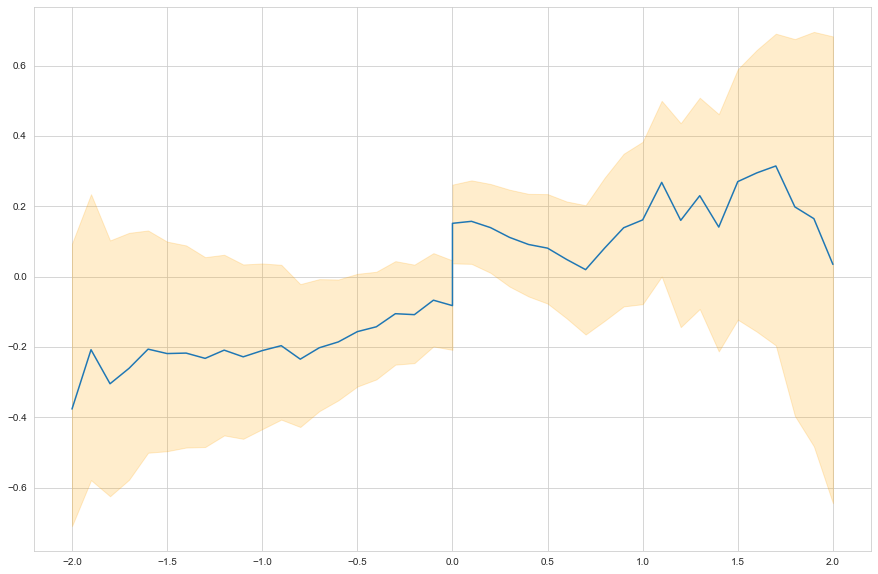

In [194]:
ac["corr"].plot()
plt.fill_between(x=ac.index, y1=ac["ci_05"], y2=ac["ci_95"], alpha=0.2, color="orange")

<AxesSubplot:>

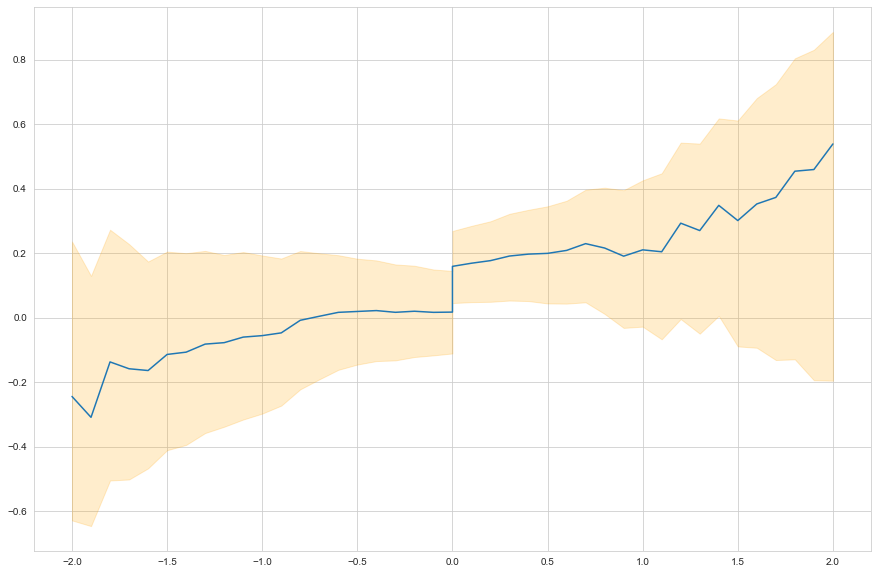

In [197]:
ac["corr"].plot()
plt.fill_between(x=ac.index, y1=ac["ci_05"], y2=ac["ci_95"], alpha=0.2, color="orange")

In [198]:
corr_down_up = (
    ac[slice(None, 0)][ac.obs>30]["corr"].mean() - 
    ac[slice(0, None)][ac.obs>30]["corr"].mean()
)
corr_down_up

C:\Users\Andreas\AppData\Local\Temp\ipykernel_22904\832629933.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ac[slice(None, 0)][ac.obs>30]["corr"].mean() -
C:\Users\Andreas\AppData\Local\Temp\ipykernel_22904\832629933.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ac[slice(0, None)][ac.obs>30]["corr"].mean()


-0.25186217571838676

<AxesSubplot:xlabel='stocks', ylabel='bonds'>

<AxesSubplot:xlabel='stocks', ylabel='bonds'>

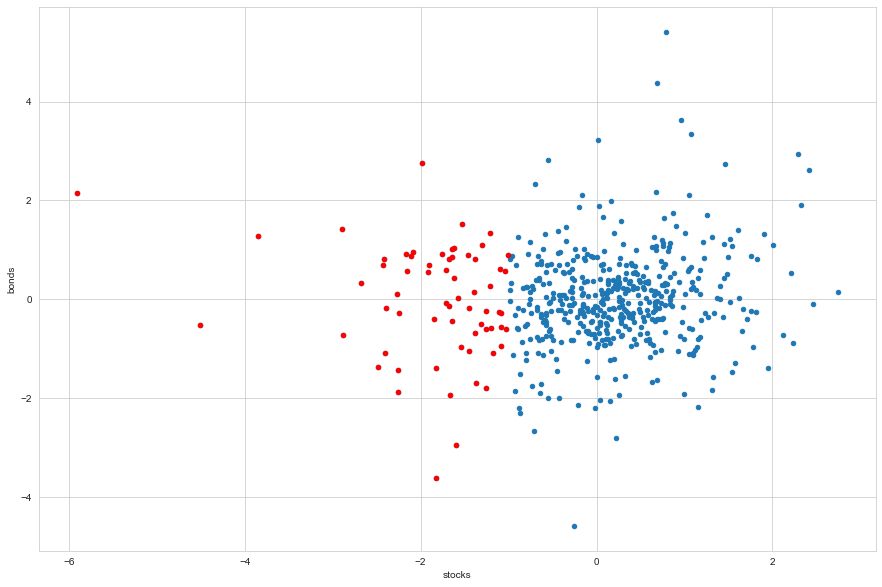

In [184]:
df.plot.scatter("stocks", "bonds")
df[df.stocks<-1].plot.scatter("stocks", "bonds", ax=plt.gca(), color="red")

In [190]:
df.corr(), df.e.corr_0()

(          stocks     bonds
 stocks  1.000000  0.084428
 bonds   0.084428  1.000000,
           stocks     bonds
 stocks  1.000000  0.084428
 bonds   0.084428  1.000000)

In [191]:
df_ = df[df.stocks<0]
df_.corr(), df_.e.corr_0()

(          stocks     bonds
 stocks  1.000000 -0.082462
 bonds  -0.082462  1.000000,
           stocks     bonds
 stocks  1.000000  0.016931
 bonds   0.016931  1.000000)